In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

In [2]:
ticker = 'kdh.bk'
data = yf.Ticker(ticker)
print(data.info)

currentprice = data.info['currentPrice']
sector = data.info['sector']
print(currentprice)
print(sector)

dr = 0.10
gr = 0.10
tgr = 0.03
year_growth = 3
year_sustain = 7
growth_to_sustain_ratio = 0.5

{'address1': '337, Somdet Prachao Taksin Road', 'address2': 'Samrae Thonburi', 'city': 'Bangkok', 'zip': '10600', 'country': 'Thailand', 'phone': '66 2 438 0040', 'fax': '66 2 438 5642', 'website': 'https://www.thonburimedicalcenter.com', 'industry': 'Medical Care Facilities', 'industryKey': 'medical-care-facilities', 'industryDisp': 'Medical Care Facilities', 'sector': 'Healthcare', 'sectorKey': 'healthcare', 'sectorDisp': 'Healthcare', 'longBusinessSummary': 'Thonburi Medical Centre Public Company Limited operates a hospital in Thailand. The company offers hair center services, such as hair treatment, hair transplantation surgery, hair laser cap, alopecia areata treatment, and face and body hair treatment; weight center services, including weight loss program, body treatment program, muscle building, skin tightening, and weight gain program; laser and special lab services comprising tattoo removal, hair removal of 2 wavelengths, and blood testing for sensitivity allergy or intoleranc

In [3]:
# data.cash_flow.index

In [4]:
### - get > Average Free cash flow , shares , Net Debt = Long Term Borrowings - Cash ###

## Shares ## 
shares = data.info['sharesOutstanding']
print('Ticker = ',ticker,' Shares = ',shares)

## Net Debt = Long Term Borrowings - Cash ###
if sector == 'Financial Services':
    totalnoncurrentliabilities = data.balancesheet.loc[data.balancesheet.index == 'Net Debt'].values[0][0]
else:
    totalnoncurrentliabilities = data.balancesheet.loc[data.balancesheet.index == 'Total Non Current Liabilities Net Minority Interest'].values[0][0] - data.balancesheet.loc[data.balancesheet.index == 'Cash And Cash Equivalents'].values[0][0]

print('Ticker = ',ticker,' Net Debt = ',totalnoncurrentliabilities)

## Average Free Cash Flow ## 
year = 4
if sector == 'Financial Services':
    averagefreecashflow = (data.cash_flow.T['Free Cash Flow'] + data.cash_flow.T['Repayment Of Debt']).dropna()[:year].mean()
    print((data.cash_flow.T['Free Cash Flow'] + data.cash_flow.T['Repayment Of Debt']).dropna()[:year])
else:
    averagefreecashflow = data.cash_flow.T['Free Cash Flow'].dropna()[:year].mean()
    print(data.cash_flow.T['Free Cash Flow'].dropna()[:year])


print('Ticker = ',ticker,'Average Free Cash Flow = ',averagefreecashflow)

Ticker =  kdh.bk  Shares =  19384200
Ticker =  kdh.bk  Net Debt =  -128890985.0
2023-12-31     80412682.0
2022-12-31    162119741.0
2021-12-31    136532358.0
2020-12-31     29202732.0
Name: Free Cash Flow, dtype: object
Ticker =  kdh.bk Average Free Cash Flow =  102066878.25


In [5]:
##### Create a DCF Function ######

def intrinsic_value(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        gr
        ):
    
    PV_1 = [averagefreecashflow * ((1+gr)**i) / ((1+dr)**i) for i in range(1,year_growth+1,1)]
    PV_2 = [averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**i)/((1+dr)**(year_growth+i)) for i in range(1,year_sustain+1,1)]
    TV = averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**(year_sustain)) * (1+tgr) / ((dr-tgr)*((1+dr)**(year_growth+year_sustain)))
    return (np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares

print(ticker + ' Intrinsic Value = ',
      intrinsic_value(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        gr
        ))

kdh.bk Intrinsic Value =  109.12215632757128


In [6]:
### Put current price as a target ### 

def intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        gr
        ):
    
    PV_1 = [averagefreecashflow * ((1+gr)**i) / ((1+dr)**i) for i in range(1,year_growth+1,1)]
    PV_2 = [averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**i)/((1+dr)**(year_growth+i)) for i in range(1,year_sustain+1,1)]
    TV = averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**(year_sustain)) * (1+tgr) / ((dr-tgr)*((1+dr)**(year_growth+year_sustain)))
    # print((((np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares)) , currentprice)
    return (((np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares) - currentprice)/currentprice

print(intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        0.15
        )*100," % ")

53.48533843390809  % 


In [7]:
def newton_raphson_method(
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice):
    
    initial_guess = 0.01
    tolerance = 0.01
    max_iterations = 100000
    x_n = initial_guess
    
    for iteration in range(max_iterations):
    # while (True):
        f_x = intrinsic_value_diff_currentprice(
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice,
            x_n
        )

        if abs(f_x) < tolerance :
            break

        x_n = x_n - f_x * 0.01

    return x_n

In [8]:
### test ###
initial_guess = 0.01
tolerance = 0.01
max_iterations = 100000

root = newton_raphson_method(           
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice)

print("Estimated GR:", root)

print(intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        root
        ) * 100," % ")


Estimated GR: 0.05566475357128594
-0.9943752568365218  % 


2.362133788862296 -0.20647781367527002


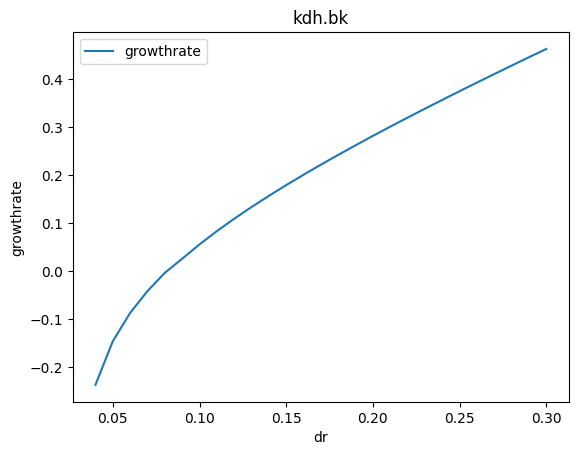

In [9]:
dr_list = [dr*0.01 for dr in range(int((tgr*100)+1),31,1)]
df = pd.DataFrame(index=dr_list,columns=['growthrate'])

growthrate = [ newton_raphson_method(           
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice) for dr in dr_list]
df['growthrate'] = growthrate
df.plot(xlabel='dr', ylabel='growthrate').set_title(ticker)

beta, alpha = np.polyfit(np.array(df.index).astype('float64'), np.array(df['growthrate']).astype('float64'),1)
print(beta,alpha)